In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import itertools
import logging
import sys
from argparse import ArgumentParser
from os.path import join
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import xarray as xr

from replay_identification import ReplayDetector
from src.load_data import load_data
from src.parameters import (FIGURE_DIR, MULTITAPER_PARAMETERS,
                            SAMPLING_FREQUENCY, USE_LIKELIHOODS,
                            detector_parameters)
from src.save_data import save_overlap, save_power, save_replay_data
from src.summarize_replay import (add_epoch_info_to_dataframe, compare_overlap,
                                  decode_replays, get_replay_times,
                                  get_replay_triggered_power,
                                  summarize_replays)
from src.visualization import plot_behavior

logging.basicConfig(level='INFO', format='%(asctime)s %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

/home/edeno/miniconda3/envs/Replay_ID_2018/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
epoch_key = 'bon', 3, 2

use_likelihoods = USE_LIKELIHOODS
position_metric = 'linear_position2'
speed_metric = 'speed'
use_smoother = True
sampling_frequency = SAMPLING_FREQUENCY

from dask.distributed import Client

Client(n_workers=14,
       threads_per_worker=4,
       processes=True,
       memory_limit='25GB')

Client Scheduler: tcp://127.0.0.1:33832 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 56 Memory: 350.00 GB


In [4]:
animal, day, epoch = epoch_key
data_types = set(itertools.chain(*use_likelihoods.values()))
data = load_data(epoch_key)

10-Sep-19 17:54:34 Loading data...
10-Sep-19 17:55:29 Failed to load file: /data2/edeno/Replay_ID_2018/src/../Raw-Data/Bond/bonDIO03.mat
10-Sep-19 17:55:29 No DIO file found, using distance from well to segment trials
10-Sep-19 17:55:29 Failed to load file: /data2/edeno/Replay_ID_2018/src/../Raw-Data/Bond/bonDIO03.mat
10-Sep-19 17:55:29 No DIO file found, inferring correct inbound/outbound from task rules
10-Sep-19 17:55:35 dav, 1, 4 not processed
10-Sep-19 17:55:38 egy, 12, 1 not processed
10-Sep-19 17:55:38 egy, 12, 2 not processed
10-Sep-19 17:55:38 egy, 12, 3 not processed
10-Sep-19 17:55:38 egy, 12, 4 not processed
10-Sep-19 17:55:38 egy, 12, 5 not processed
10-Sep-19 17:55:38 egy, 12, 6 not processed
10-Sep-19 17:55:38 egy, 12, 7 not processed
10-Sep-19 17:55:38 egy, 12, 8 not processed
10-Sep-19 17:55:38 fra, 4, 1 not processed
10-Sep-19 17:55:39 gov, 2, 3 not processed
10-Sep-19 17:55:39 gov, 2, 4 not processed
10-Sep-19 17:55:39 gov, 2, 5 not processed
10-Sep-19 17:55:39 gov, 

In [5]:
replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

10-Sep-19 17:58:06 ReplayDetector(infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='w_track_1D_random_walk',
               movement_var=4.0,
               multiunit_density_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               multiunit_mo...: array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=5,
               spike_model_penalty=0.5)


In [6]:
track_labels = data['position_info'].arm_name
replay_detector.fit(
    is_ripple=data['is_ripple'], speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric],
    lfp_power=data['ripple_power'], spikes=data['spikes'],
    multiunit=data['multiunit'], track_labels=track_labels)

10-Sep-19 17:58:06 Fitting speed model...
10-Sep-19 17:58:07 Fitting LFP power model...
10-Sep-19 17:58:07 Fitting spiking model...


10-Sep-19 18:04:32 Fitting multiunit model...


10-Sep-19 18:04:35 Fitting replay movement state transition...


10-Sep-19 18:04:36 Fitting replay state transition...


ReplayDetector(infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='w_track_1D_random_walk',
               movement_var=4.0,
               multiunit_density_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               multiunit_mo...: array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=5,
               spike_model_penalty=0.5)

In [7]:
use_likelihoods

OrderedDict([('lfp_power', ['lfp_power']),
             ('sorted_spikes', ['spikes']),
             ('clusterless', ['multiunit']),
             ('ad_hoc_ripple', ['ad_hoc_ripple']),
             ('ad_hoc_multiunit', ['ad_hoc_multiunit'])])

In [8]:
data_source, likelihoods  = 'clusterless', ['multiunit']

logging.info(f'Finding replays with {data_source}...')
if data_source == 'ad_hoc_ripple':
    replay_info = data['ripple_times'].copy()
    is_replay = data['ripple_labels'].copy()
    detector_results = []
elif data_source == 'ad_hoc_multiunit':
    replay_info = data['multiunit_high_synchrony_times'].copy()
    is_replay = data['multiunit_high_synchrony_labels'].copy()
    detector_results = []
else:
    detector_results = replay_detector.predict(
        speed=data['position_info'][speed_metric],
        position=data['position_info'][position_metric],
        lfp_power=data['ripple_power'],
        spikes=data['spikes'], multiunit=data['multiunit'],
        time=data['position_info'].index,
        use_likelihoods=likelihoods,
        use_smoother=use_smoother)
    replay_info, is_replay = get_replay_times(detector_results)

10-Sep-19 18:04:43 Finding replays with clusterless...
10-Sep-19 18:04:43 Predicting multiunit likelihood...


10-Sep-19 23:22:37 Finding causal replay probability and position...
10-Sep-19 23:23:49 Finding acausal replay probability and position...


In [9]:
logging.info(detector_results)

10-Sep-19 23:26:57 <xarray.Dataset>
Dimensions:             (position: 185, state: 2, time: 930994)
Coordinates:
  * time                (time) timedelta64[ns] 01:02:09.025700 ... 01:17:40.018700
  * position            (position) float64 -0.9949 0.9949 2.985 ... 363.1 365.1
  * state               (state) <U9 'No Replay' 'Replay'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 1.171e-51
    likelihood          (time, state, position) float64 0.0 0.8154 ... 1.0
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 1.171e-51
    replay_probability  (time) float64 0.0 2.261e-12 ... 1.345e-49 1.592e-49


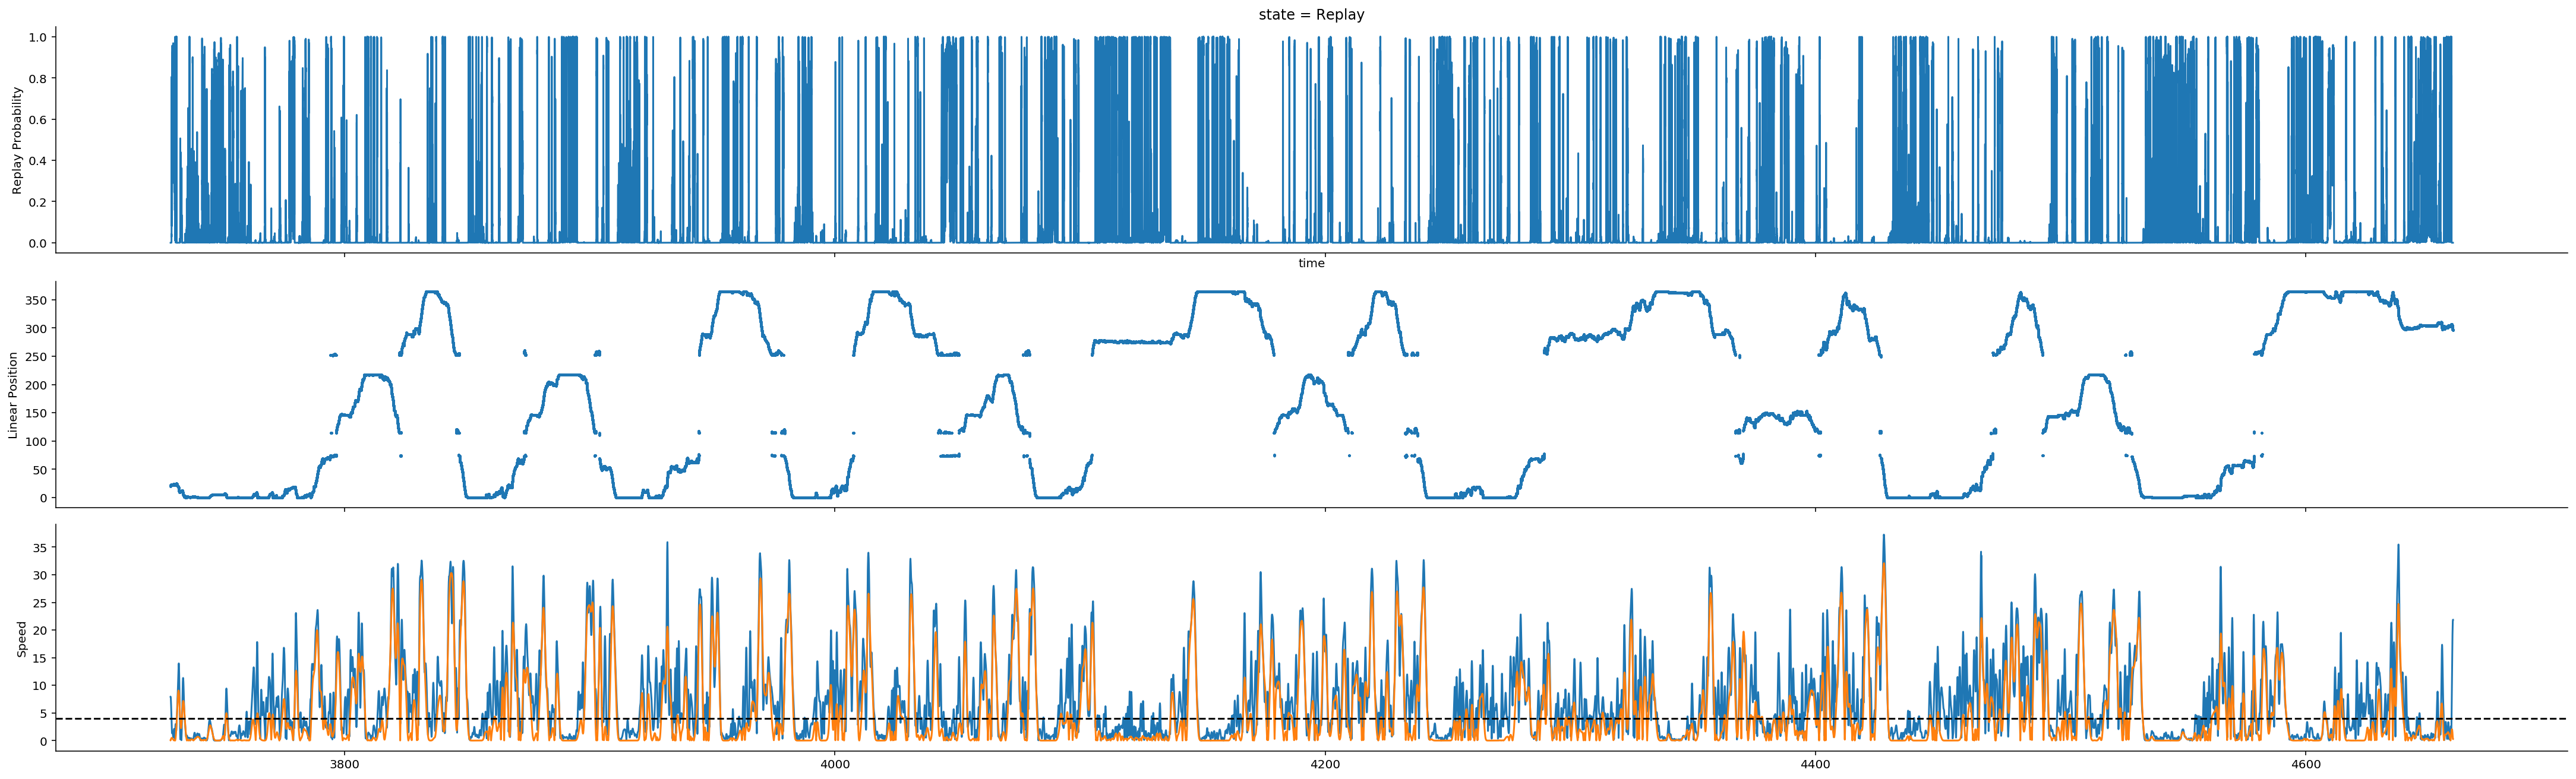

In [10]:
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(30, 9), constrained_layout=True, sharex=True)
detector_results.causal_posterior.sum('position').assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's')).sel(state='Replay').plot(x='time', ax=axes[0])
axes[0].set_ylabel('Replay Probability')

axes[1].scatter(data['position_info'].index.total_seconds(), data['position_info'][position_metric].values, s=1)
axes[1].set_ylabel('Linear Position')

axes[2].plot(data['position_info'].index.total_seconds(), data['position_info'][speed_metric].values)
axes[2].plot(data['position_info'].index.total_seconds(), data['position_info']['linear_speed'].values)
axes[2].axhline(4, linestyle='--', color='black')
axes[2].set_ylabel('Speed')
sns.despine()

IndexError: index 930994 is out of bounds for axis 0 with size 930994

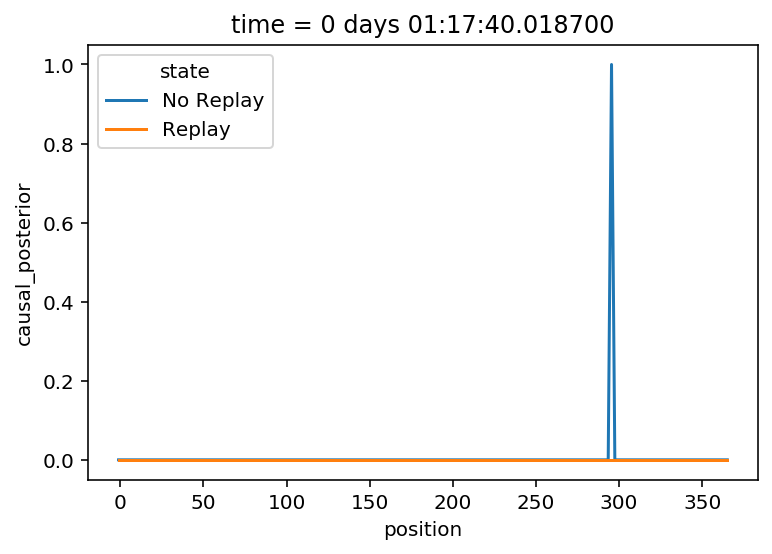

<Figure size 432x288 with 0 Axes>

In [11]:
max_na_time = detector_results.causal_posterior.dropna('time').time.argmax()

detector_results.causal_posterior.isel(time=max_na_time).plot(x='position', hue='state')

plt.figure()
detector_results.causal_posterior.isel(time=max_na_time + 1).plot(x='position', hue='state')

In [ ]:
detector_results.likelihood.isel(time=max_na_time).plot(x='position', hue='state')

plt.figure()
detector_results.likelihood.isel(time=max_na_time + 1).plot(x='position', hue='state')

plt.figure()
detector_results.likelihood.isel(time=max_na_time + 3).plot(x='position', hue='state')

In [ ]:
data['multiunit'].isel(time=max_na_time)

In [ ]:
data['multiunit'].isel(time=max_na_time + 1, tetrodes=-1)

In [ ]:
data['multiunit'].isel(time=max_na_time + 3)

In [ ]:
from replay_identification.multiunit_likelihood import estimate_replay_log_likelihood, estimate_no_replay_log_likelihood
import numpy as np

time_ind = [max_na_time, max_na_time+1, max_na_time+2, max_na_time+3]
multiunits = np.asarray(data['multiunit'].isel(time=time_ind))
place_bin_centers = replay_detector.place_bin_centers_

occupancy_model = replay_detector._multiunit_likelihood.keywords['occupancy_model']
joint_models = replay_detector._multiunit_likelihood.keywords['joint_models']
marginal_models = replay_detector._multiunit_likelihood.keywords['marginal_models']
mean_rates = replay_detector._multiunit_likelihood.keywords['mean_rates']
is_track_interior = replay_detector._multiunit_likelihood.keywords['is_track_interior']
time_bin_size = 1

n_time = multiunits.shape[0]
n_place_bins = place_bin_centers.size
multiunit_likelihood = np.zeros((n_time, 2, n_place_bins))
position = data['position_info'][position_metric].iloc[time_ind].values

multiunit_likelihood[:, 1, :] = (estimate_replay_log_likelihood(
    np.moveaxis(multiunits, -1, 0), place_bin_centers,
    occupancy_model, joint_models, marginal_models, mean_rates,
    is_track_interior, time_bin_size))
multiunit_likelihood[:, 0, :] = (estimate_no_replay_log_likelihood(
    np.moveaxis(multiunits, -1, 0), position, occupancy_model,
    joint_models, marginal_models, mean_rates, time_bin_size))

multiunit_likelihood[:, :, ~is_track_interior.squeeze()] = 0.0

In [ ]:
plt.plot(scale_likelihood(multiunit_likelihood)[1, 0, :])
plt.plot(is_track_interior)

In [ ]:
plt.plot(multiunit_likelihood[1, 1, :])
plt.plot(is_track_interior)

In [ ]:
from tqdm.autonotebook import tqdm
from replay_identification.multiunit_likelihood import estimate_occupancy, estimate_ground_process_intensity, estimate_log_joint_mark_intensity, poisson_mark_log_likelihood
from replay_identification.core import scale_likelihood

n_bin = place_bin_centers.size
log_likelihood = []

occupancy = estimate_occupancy(place_bin_centers, occupancy_model)

for multiunit, joint_model, marginal_model, mean_rate in zip(
        tqdm(np.moveaxis(multiunits, -1, 0), desc='electrodes'), joint_models, marginal_models,
        mean_rates):
    ground_process_intensity = np.atleast_2d(
        estimate_ground_process_intensity(
            place_bin_centers, occupancy, marginal_model, mean_rate))
    log_joint_mark_intensity = np.ones((n_time, n_bin))
    log_joint_mark_intensity[:, is_track_interior] = np.stack([
        estimate_log_joint_mark_intensity(
            multiunit, place_bin * np.ones((n_time, 1)), joint_model,
            mean_rate, occ * np.ones((n_time,)))
        for occ, place_bin in zip(occupancy[is_track_interior],
                                  place_bin_centers[is_track_interior])],
                                  axis=1)
    log_joint_mark_intensity[:, ~is_track_interior.squeeze()] = np.nan
    log_likelihood.append( poisson_mark_log_likelihood(
        log_joint_mark_intensity, ground_process_intensity, time_bin_size))

In [ ]:
for ll in log_likelihood:
    plt.plot(np.exp(ll[1]))

In [ ]:
for ll in log_likelihood:
    plt.plot(scale_likelihood(ll[:, np.newaxis, :])[1].squeeze())

In [ ]:
plt.plot(scale_likelihood(np.sum([ll for ll in log_likelihood[-10:]], axis=0)[:, np.newaxis, :])[1].squeeze())

In [ ]:
[np.sum(np.exp(ll[1]) < np.spacing(1)) > 100 for ll in log_likelihood]

In [ ]:
log_likelihood[8].shape